In [1]:
from keras.layers import Input, Conv2D, UpSampling2D
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, Input
import keras.backend as K
import sys
import os
import numpy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import Callback
import numpy as np
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Input
from keras.utils.data_utils import get_file
import keras.backend as K
import h5py
import numpy as np
import tensorflow as tf
from sklearn.datasets import fetch_lfw_people
import cv2
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow import keras

import PIL.Image

Using TensorFlow backend.


In [2]:
def decoder_layers(inputs, layer):
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block5_conv1')(inputs)
    if layer == 1:
        return x

    x = UpSampling2D((2, 2), name='decoder_block4_upsample')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv4')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv1')(x)
    if layer == 2:
        return x

    x = UpSampling2D((2, 2), name='decoder_block3_upsample')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv4')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv1')(x)
    if layer == 3:
        return x

    x = UpSampling2D((2, 2), name='decoder_block2_upsample')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv2')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv1')(x)
    if layer == 4:
        return x

    x = UpSampling2D((2, 2), name='decoder_block1_upsample')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv2')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv1')(x)
    if layer == 5:
        return x

## Problems with the above code

The above code does not create the layers in the correct cases. What we want if the reverse order of VGG19 starting with the last used layer and ending with the first layer of VGG. For instances if we stopped at layer 4 (conv4_1) we will start decoding with conv4_1 and then upsample and make our way though to the beginning of VGG. 

In [3]:
def decoder_layers(inputs, layer):
    
    x = None
    if layer == 5:
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block5_conv1')(inputs)
        x = UpSampling2D((2, 2), name='decoder_block4_upsample')(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv4')(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv3')(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv2')(x)
    
    if layer >= 4:
        if x is None:
            x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv1')(inputs)
        else:
            x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv1')(x)
        x = UpSampling2D((2, 2), name='decoder_block3_upsample')(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv4')(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv3')(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv2')(x)
        
    if layer >= 3:
        if x is None:
            x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv1')(inputs)
        else:
            x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv1')(x)
        x = UpSampling2D((2, 2), name='decoder_block2_upsample')(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv2')(x)

    if layer >= 2:
        if x is None:
            x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv1')(inputs)
        else:
            x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv1')(x)
        x = UpSampling2D((2, 2), name='decoder_block1_upsample')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv2')(x)
    
    if layer >= 1:
        if x is None:
            x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv1')(inputs)
        else:
            x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv1')(x)
    return x

In [4]:
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

MEAN_PIXEL = np.array([103.939, 116.779, 123.68])

WEIGHTS_PATH = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        WEIGHTS_PATH_NO_TOP,
                        cache_subdir='models',
                        file_hash='253f8cb515780f3b799900260a226db6')

def vgg_layers(inputs, target_layer):
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    if target_layer == 1:
        return x
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    if target_layer == 2:
        return x
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    if target_layer == 3:
        return x
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    if target_layer == 4:
        return x
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    
    return x


def load_weights(model):
    f = h5py.File(WEIGHTS_PATH)
    layer_names = [name for name in f.attrs['layer_names']]

    for layer in model.layers:
        b_name = layer.name.encode()
        if b_name in layer_names:
            g = f[b_name]
            weights = [g[name] for name in g.attrs['weight_names']]
            layer.set_weights(weights)
            layer.trainable = False

    f.close()


def VGG19(input_tensor=None, input_shape=None, target_layer=1):
    """
    VGG19, up to the target layer (1 for relu1_1, 2 for relu2_1, etc.)
    """
    if input_tensor is None:
        inputs = Input(shape=input_shape)
    else:
        inputs = Input(tensor=input_tensor, shape=input_shape)
    model = Model(inputs, vgg_layers(inputs, target_layer), name='vgg19')
    load_weights(model)
    return model


def preprocess_input(x):
    # Convert 'RGB' -> 'BGR'
    if type(x) is np.ndarray:
        x = x[..., ::-1]
    else:
        x = tf.reverse(x, [-1])

    return x - MEAN_PIXEL


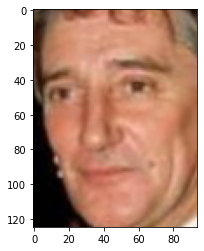

In [5]:
import matplotlib.pyplot as plt 

lfw_people = fetch_lfw_people(min_faces_per_person=1, resize=1, color=True)
lfw_people = lfw_people.images
lfw_people = lfw_people.astype('uint8')
plt.imshow(lfw_people[85])

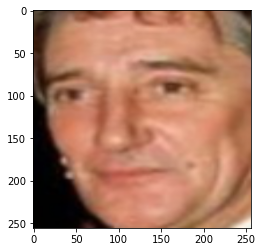

Wall time: 9.88 s


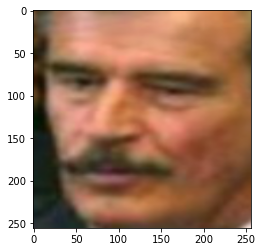

In [21]:
%%time
resized_faces = []
for face in lfw_people:
    img = face.astype('uint8')
    resized_faces.append(cv2.resize(img, dsize=(256,256)))
    
resized_faces = np.array(resized_faces)

img = resized_faces[85].astype('uint8')
plt.imshow(cv2.resize(img, dsize=(256,256)))
plt.show()

img = resized_faces[86].astype('uint8')
plt.imshow(cv2.resize(img, dsize=(256,256)))

In [22]:
resized_faces = resized_faces.astype('float32') / 255

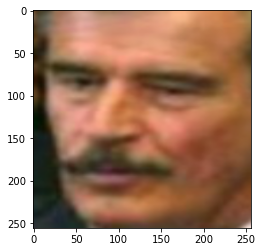

In [23]:
plt.imshow(resized_faces[86])

In [64]:
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

In [10]:
LAMBDA=1

def l2_loss(x):
    return K.sum(K.square(x)) / 2

class EncoderDecoder:
    def __init__(self, input_shape=(256,256,3), target_layer=5, decoder_path=None, opt='adam'):

        self.input_shape = input_shape
        self.target_layer = target_layer

        self.encoder = VGG19(input_shape=input_shape, target_layer=target_layer)
        if decoder_path:
            self.decoder = load_model(decoder_path)
        else:
            self.decoder = self.create_decoder(target_layer)

        self.model = Sequential()
        self.model.add(self.encoder)
        self.model.add(self.decoder)
        self.model.add(Conv2D(3, (3, 3), activation='relu', padding='same',
                              name='decoder_out'))
        
        self.loss = self.create_loss_fn(self.encoder)
        
        self.model.compile(optimizer=opt, loss=self.loss)
        
        
    def create_loss_fn(self, encoder):
        def get_encodings(inputs):
            encoder = VGG19(inputs, self.input_shape, self.target_layer)
            return encoder.output

        def loss(img_in, img_out):
            encoding_in = get_encodings(img_in)
            encoding_out = get_encodings(img_out)
            return l2_loss(img_out - img_in) + \
                   LAMBDA*l2_loss(encoding_out - encoding_in)
        return loss

    def create_decoder(self, target_layer):
        inputs = Input(shape=self.encoder.output_shape[1:], name="decoder_input")
        layers = decoder_layers(inputs, target_layer)
        return Model(inputs, layers, name='decoder_%s' % target_layer)
    
    def export_decoder(self):
        self.decoder.save('decoder_%s.h5' % self.target_layer)
    def export_model(self):
        self.model.save('./TrainedModels/Block%s_Model/saved_model.pb' % self.target_layer)
    
    def load_decoder(self):
        self.decoder = keras.models.load_model('decoder_%s.h5' % self.target_layer)
        self.decoder.compile('adam', self.loss)
        self.model.compile('adam', self.loss)
    def load_model(self):
        self.model = keras.models.load_model('./TrainedModels/Block%s_Model/saved_model.pb' % self.target_layer, compile=False)
        self.encoder = self.model.layers[0]
        self.decoder = self.model.layers[1]

In [67]:
encoder_decoder = EncoderDecoder(input_shape=(256, 256, 3), target_layer=2)

In [50]:
encoder_decoder.encoder.output_shape

(None, 128, 128, 128)

In [51]:
encoder_decoder.encoder.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
Total params: 112,576
Trainable params: 0
Non-trainable params: 112,576
_________________________________________________________________


In [52]:
encoder_decoder.decoder.summary()

Model: "decoder_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 128, 128, 128)     0         
_________________________________________________________________
decoder_block2_conv1 (Conv2D (None, 128, 128, 128)     147584    
_________________________________________________________________
decoder_block1_upsample (UpS (None, 256, 256, 128)     0         
_________________________________________________________________
decoder_block1_conv2 (Conv2D (None, 256, 256, 64)      73792     
_________________________________________________________________
decoder_block1_conv1 (Conv2D (None, 256, 256, 64)      36928     
Total params: 258,304
Trainable params: 258,304
Non-trainable params: 0
_________________________________________________________________


In [11]:
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12.8,4.8))
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
def plot_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12.8,4.8))
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.legend()
    plt.show()

#plot_history(history)

In [12]:
# This is from 05c UniversalStyleTransfer.ipynb
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def plot_img_decoder_encoder(img, model):
    input_img = np.asarray(img)
    input_img = cv2.resize(input_img, dsize=(256,256))
    input_img = input_img.reshape(1, 256, 256,3)
    out_sample = model.predict(input_img)
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.imshow(tensor_to_image(out_sample))
    print(np.mean(np.square(out_sample - input_img)))
    plt.show()

In [13]:
X = resized_faces
y = resized_faces
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Train Layer 1

In [43]:
encoder_decoder = EncoderDecoder(input_shape=(256, 256, 3), target_layer=1)

In [44]:
encoder_decoder.model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 256, 256, 64)      1792      
_________________________________________________________________
decoder_1 (Model)            (None, 256, 256, 64)      36928     
_________________________________________________________________
decoder_out (Conv2D)         (None, 256, 256, 3)       1731      
Total params: 40,451
Trainable params: 38,659
Non-trainable params: 1,792
_________________________________________________________________


In [45]:
encoder_decoder.encoder.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
Total params: 1,792
Trainable params: 0
Non-trainable params: 1,792
_________________________________________________________________


In [46]:
encoder_decoder.decoder.summary()

Model: "decoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 256, 256, 64)      0         
_________________________________________________________________
decoder_block1_conv1 (Conv2D (None, 256, 256, 64)      36928     
Total params: 36,928
Trainable params: 36,928
Non-trainable params: 0
_________________________________________________________________


In [47]:
%%time
LAMBDA = 2
history = encoder_decoder.model.fit(X_train, y_train, 
                                    validation_data=(X_test, y_test),
                                    epochs=10, batch_size=1, verbose=True)

Train on 10586 samples, validate on 2647 samples
Epoch 1/10
10586/10586 [==============================] - 73s 7ms/step - loss: 341025.4449 - val_loss: 340345.0233
Epoch 2/10
10586/10586 [==============================] - 72s 7ms/step - loss: 36128.2203 - val_loss: 6110.9194
Epoch 3/10
10586/10586 [==============================] - 72s 7ms/step - loss: 5370.0279 - val_loss: 4987.4812
Epoch 4/10
10586/10586 [==============================] - 72s 7ms/step - loss: 5292.9805 - val_loss: 4727.4873
Epoch 5/10
10586/10586 [==============================] - 72s 7ms/step - loss: 5269.7473 - val_loss: 4342.2438
Epoch 6/10
10586/10586 [==============================] - 71s 7ms/step - loss: 5267.0174 - val_loss: 4364.0246
Epoch 7/10
10586/10586 [==============================] - 72s 7ms/step - loss: 5253.2865 - val_loss: 6327.4100
Epoch 8/10
10586/10586 [==============================] - 72s 7ms/step - loss: 5229.9072 - val_loss: 4433.9741
Epoch 9/10
10586/10586 [==============================] - 

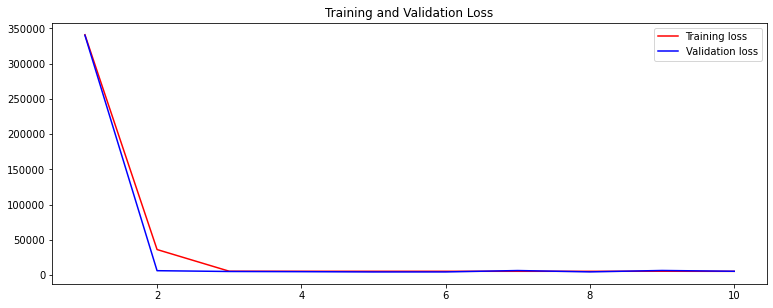

In [48]:
plot_history(history)

0.00016316901


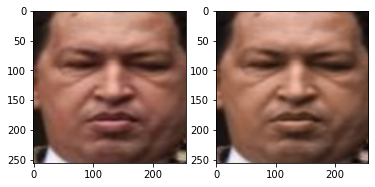

0.0001432761


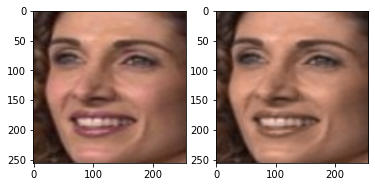

In [49]:

plot_img_decoder_encoder(resized_faces[80], encoder_decoder.model)

plot_img_decoder_encoder(resized_faces[81], encoder_decoder.model)

In [50]:
encoder_decoder.export_model()

In [51]:
encoder_decoder_1 = EncoderDecoder(input_shape=(256, 256, 3), target_layer=1)

In [52]:
encoder_decoder_1.load_model()

0.00016316901


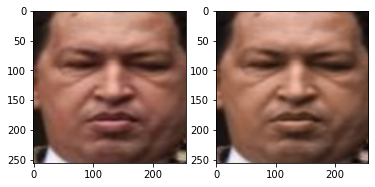

0.0001432761


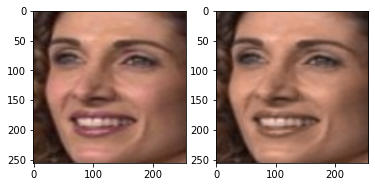

In [53]:
plot_img_decoder_encoder(resized_faces[80], encoder_decoder_1.model)

plot_img_decoder_encoder(resized_faces[81], encoder_decoder_1.model)

______

# Layer 2

In [22]:
encoder_decoder = EncoderDecoder(input_shape=(256, 256, 3), target_layer=2)

In [32]:
encoder_decoder.model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 128, 128, 128)     112576    
_________________________________________________________________
decoder_2 (Model)            (None, 256, 256, 64)      258304    
_________________________________________________________________
decoder_out (Conv2D)         (None, 256, 256, 3)       1731      
Total params: 372,611
Trainable params: 260,035
Non-trainable params: 112,576
_________________________________________________________________


In [34]:
encoder_decoder.encoder.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
Total params: 112,576
Trainable params: 0
Non-trainable params: 112,576
_________________________________________________________________


In [33]:
encoder_decoder.decoder.summary()

Model: "decoder_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 128, 128, 128)     0         
_________________________________________________________________
decoder_block2_conv1 (Conv2D (None, 128, 128, 128)     147584    
_________________________________________________________________
decoder_block1_upsample (UpS (None, 256, 256, 128)     0         
_________________________________________________________________
decoder_block1_conv2 (Conv2D (None, 256, 256, 64)      73792     
_________________________________________________________________
decoder_block1_conv1 (Conv2D (None, 256, 256, 64)      36928     
Total params: 258,304
Trainable params: 258,304
Non-trainable params: 0
_________________________________________________________________


In [58]:
%%time
LAMBDA=2
encoder_decoder = EncoderDecoder(input_shape=(256, 256, 3), target_layer=2)
history_2 = encoder_decoder.model.fit(X_train, y_train, 
                                    validation_data=(X_test, y_test),
                                    epochs=80, batch_size=5, verbose=True)

Train on 10586 samples, validate on 2647 samples
Epoch 1/80
10586/10586 [==============================] - 151s 14ms/step - loss: 6045125.1236 - val_loss: 5993464.5370
Epoch 2/80
10586/10586 [==============================] - 151s 14ms/step - loss: 6030776.6038 - val_loss: 5993464.1553
Epoch 3/80
10586/10586 [==============================] - 151s 14ms/step - loss: 6030600.7063 - val_loss: 5993456.1534
Epoch 4/80
10586/10586 [==============================] - 150s 14ms/step - loss: 6030835.8677 - val_loss: 5993461.7595
Epoch 5/80
10586/10586 [==============================] - 150s 14ms/step - loss: 6030636.4486 - val_loss: 5993468.8328
Epoch 6/80
10586/10586 [==============================] - 151s 14ms/step - loss: 6030855.8102 - val_loss: 5993458.6080
Epoch 7/80
10586/10586 [==============================] - 150s 14ms/step - loss: 6030607.4279 - val_loss: 5993455.8461
Epoch 8/80
10586/10586 [==============================] - 151s 14ms/step - loss: 6039758.9770 - val_loss: 5993708.7057

Epoch 69/80
10586/10586 [==============================] - 152s 14ms/step - loss: 6031122.0774 - val_loss: 5993708.7057
Epoch 70/80
10586/10586 [==============================] - 152s 14ms/step - loss: 6031066.5776 - val_loss: 5993708.7057
Epoch 71/80
10586/10586 [==============================] - 152s 14ms/step - loss: 6031060.4314 - val_loss: 5993708.7057
Epoch 72/80
10586/10586 [==============================] - 150s 14ms/step - loss: 6031079.1638 - val_loss: 5993708.7057
Epoch 73/80
10586/10586 [==============================] - 151s 14ms/step - loss: 6031004.3868 - val_loss: 5993708.7057
Epoch 74/80
10586/10586 [==============================] - 150s 14ms/step - loss: 6031062.3705 - val_loss: 5993708.7057
Epoch 75/80
10586/10586 [==============================] - 151s 14ms/step - loss: 6031098.7497 - val_loss: 5993708.7057
Epoch 76/80
10586/10586 [==============================] - 150s 14ms/step - loss: 6031127.5695 - val_loss: 5993708.7057
Epoch 77/80
10586/10586 [===============

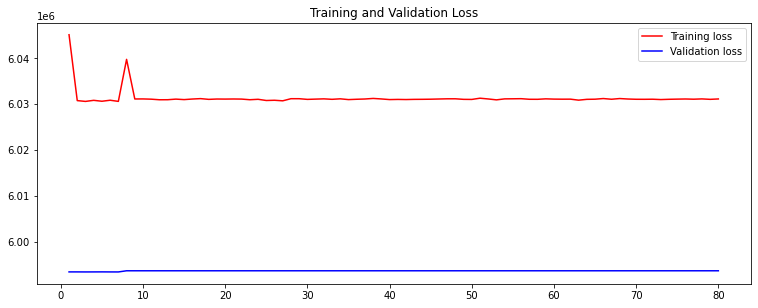

In [59]:
plot_history(history_2)

0.20371221


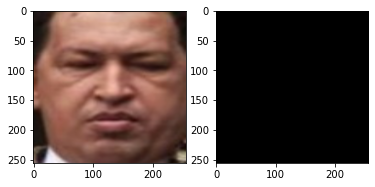

0.22742419


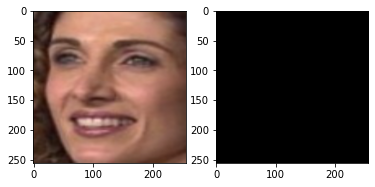

In [60]:
plot_img_decoder_encoder(resized_faces[80], encoder_decoder.model)

plot_img_decoder_encoder(resized_faces[81], encoder_decoder.model)

In [61]:
%%time
LAMBDA=1
encoder_decoder_2 = EncoderDecoder(input_shape=(256, 256, 3), target_layer=2)
history_2_2 = encoder_decoder_2.model.fit(X_train, y_train, 
                                    validation_data=(X_test, y_test),
                                    epochs=80, batch_size=5, verbose=True)

Train on 10586 samples, validate on 2647 samples
Epoch 1/80
10586/10586 [==============================] - 151s 14ms/step - loss: 3132543.6679 - val_loss: 3070609.4806
Epoch 2/80
10586/10586 [==============================] - 151s 14ms/step - loss: 3089427.1075 - val_loss: 3070609.4806
Epoch 3/80
10586/10586 [==============================] - 151s 14ms/step - loss: 3089402.1037 - val_loss: 3070609.4806
Epoch 4/80
10586/10586 [==============================] - 151s 14ms/step - loss: 3089376.5289 - val_loss: 3070609.4806
Epoch 5/80
10586/10586 [==============================] - 151s 14ms/step - loss: 3089461.2734 - val_loss: 3070609.4806
Epoch 6/80
10586/10586 [==============================] - 151s 14ms/step - loss: 3089466.6679 - val_loss: 3070609.4806
Epoch 7/80
10586/10586 [==============================] - 150s 14ms/step - loss: 3089429.4571 - val_loss: 3070609.4806
Epoch 8/80
10586/10586 [==============================] - 152s 14ms/step - loss: 3089471.3893 - val_loss: 3070609.4806

Epoch 69/80
10586/10586 [==============================] - 150s 14ms/step - loss: 3089389.6609 - val_loss: 3070609.4806
Epoch 70/80
10586/10586 [==============================] - 151s 14ms/step - loss: 3089463.8545 - val_loss: 3070609.4806
Epoch 71/80
10586/10586 [==============================] - 151s 14ms/step - loss: 3089461.0834 - val_loss: 3070609.4806
Epoch 72/80
10586/10586 [==============================] - 151s 14ms/step - loss: 3089362.2876 - val_loss: 3070609.4806
Epoch 73/80
10586/10586 [==============================] - 151s 14ms/step - loss: 3089417.0365 - val_loss: 3070609.4806
Epoch 74/80
10586/10586 [==============================] - 151s 14ms/step - loss: 3089435.4938 - val_loss: 3070609.4806
Epoch 75/80
10586/10586 [==============================] - 151s 14ms/step - loss: 3089417.7401 - val_loss: 3070609.4806
Epoch 76/80
10586/10586 [==============================] - 151s 14ms/step - loss: 3089412.0027 - val_loss: 3070609.4806
Epoch 77/80
10586/10586 [===============

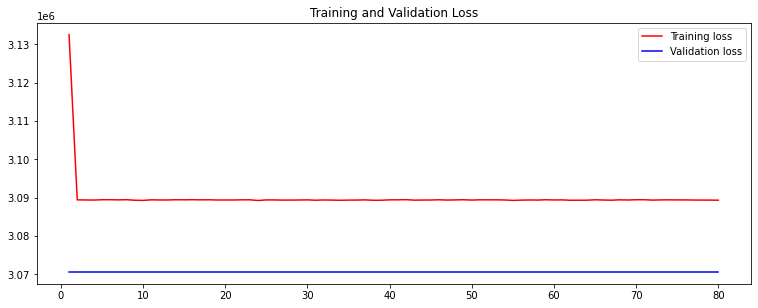

In [62]:
plot_history(history_2_2)

0.20371221


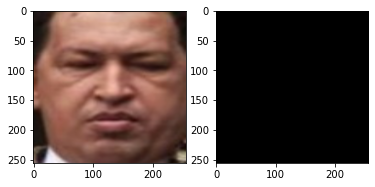

0.22742419


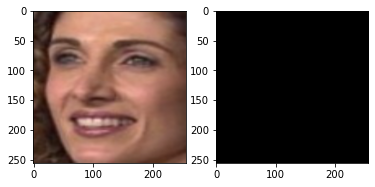

In [63]:
plot_img_decoder_encoder(resized_faces[80], encoder_decoder_2.model)

plot_img_decoder_encoder(resized_faces[81], encoder_decoder_2.model)

In [68]:
%%time
LAMBDA=1
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
encoder_decoder_2 = EncoderDecoder(input_shape=(256, 256, 3), target_layer=2, opt=opt)
history_2_2 = encoder_decoder_2.model.fit(X_train, y_train, 
                                    validation_data=(X_test, y_test),
                                    epochs=80, batch_size=5, verbose=True)

Train on 10586 samples, validate on 2647 samples
Epoch 1/80
10586/10586 [==============================] - 149s 14ms/step - loss: 3096887.9069 - val_loss: 3049019.1595
Epoch 2/80
10586/10586 [==============================] - 150s 14ms/step - loss: 646030.8961 - val_loss: 24059.2895
Epoch 3/80
10586/10586 [==============================] - 150s 14ms/step - loss: 16397.1626 - val_loss: 15204.1726
Epoch 4/80
10586/10586 [==============================] - 150s 14ms/step - loss: 10685.3641 - val_loss: 8914.0952
Epoch 5/80
10586/10586 [==============================] - 151s 14ms/step - loss: 8295.9661 - val_loss: 9704.1650
Epoch 6/80
10586/10586 [==============================] - 150s 14ms/step - loss: 6778.5658 - val_loss: 6243.3250
Epoch 7/80
10586/10586 [==============================] - 150s 14ms/step - loss: 5853.6446 - val_loss: 7532.9279
Epoch 8/80
10586/10586 [==============================] - 150s 14ms/step - loss: 5254.4676 - val_loss: 30506.4462
Epoch 9/80
10586/10586 [==========

2.27938e-05


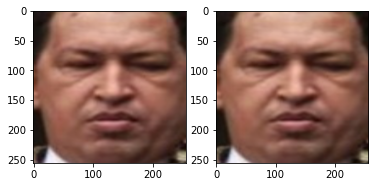

2.3571278e-05


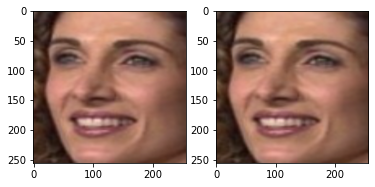

In [69]:
plot_img_decoder_encoder(resized_faces[80], encoder_decoder_2.model)

plot_img_decoder_encoder(resized_faces[81], encoder_decoder_2.model)

In [72]:
encoder_decoder_2.export_model()

_________________________________________

# Train Layer 3

In [25]:
X = resized_faces
y = resized_faces
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

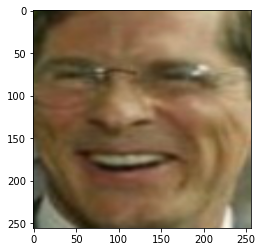

In [27]:
plt.imshow(X_train[86])

In [40]:
%%time
LAMBDA=1
opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
encoder_decoder_3 = EncoderDecoder(input_shape=(256, 256, 3), target_layer=3, opt=opt)
history_3 = encoder_decoder_3.model.fit(X_train, y_train, 
                                    validation_data=(X_test, y_test),
                                    epochs=120, batch_size=5, verbose=True)

C:\Users\Steven\anaconda3\envs\lab-1-tensor\lib\site-packages\ipykernel_launcher.py:50: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


Train on 10586 samples, validate on 2647 samples
Epoch 1/120
10586/10586 [==============================] - 224s 21ms/step - loss: 3614581.3858 - val_loss: 3389783.5947
Epoch 2/120
10586/10586 [==============================] - 224s 21ms/step - loss: 3335282.4475 - val_loss: 3330214.1331
Epoch 3/120
10586/10586 [==============================] - 224s 21ms/step - loss: 3289702.6873 - val_loss: 3298252.4589
Epoch 4/120
10586/10586 [==============================] - 224s 21ms/step - loss: 2484499.2145 - val_loss: 1754029.7934
Epoch 5/120
10586/10586 [==============================] - 224s 21ms/step - loss: 1665498.6316 - val_loss: 1651846.9488
Epoch 6/120
10586/10586 [==============================] - 224s 21ms/step - loss: 1621055.8040 - val_loss: 1618193.0624
Epoch 7/120
10586/10586 [==============================] - 224s 21ms/step - loss: 1593419.0521 - val_loss: 1595403.5634
Epoch 8/120
10586/10586 [==============================] - 225s 21ms/step - loss: 1574589.2580 - val_loss: 1575

0.00015703462


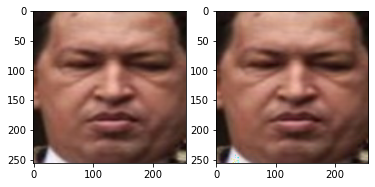

0.00020517658


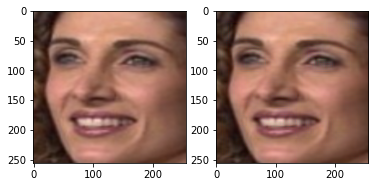

In [41]:
plot_img_decoder_encoder(resized_faces[80], encoder_decoder_3.model)

plot_img_decoder_encoder(resized_faces[81], encoder_decoder_3.model)

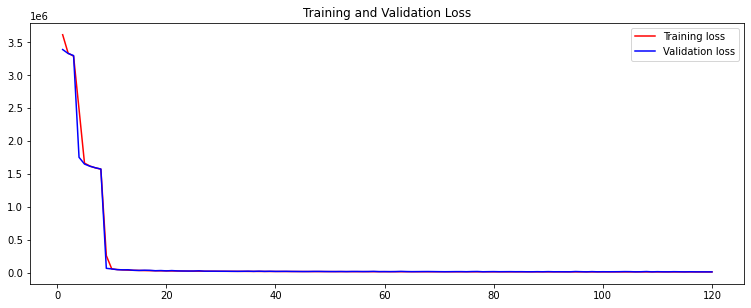

In [42]:
plot_history(history_3)

In [47]:
encoder_decoder_3.export_model()

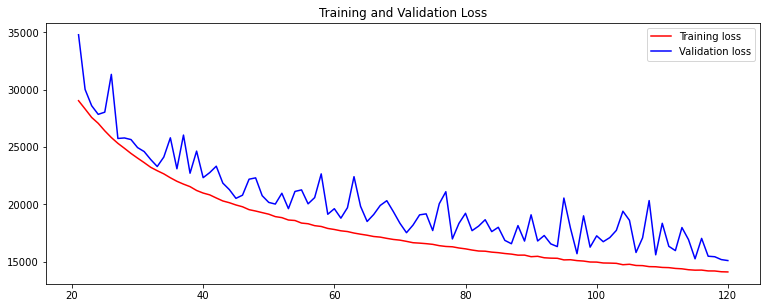

In [45]:
def plot_history_end(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)[20:]

    plt.figure(figsize=(12.8,4.8))
    plt.plot(epochs, loss[20:], 'r', label='Training loss')
    plt.plot(epochs, val_loss[20:], 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    

plot_history_end(history_3)